In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../pipeline/')
from settings import output_path
output_path = os.path.join(output_path, '../')
IDIBAPS_path = os.path.join(os.path.dirname(output_path), 'IDIBAPS')
LENS_path = os.path.join(os.path.dirname(output_path), 'LENS')

In [2]:
vdf_IDIBAPS = pd.read_csv(os.path.join(IDIBAPS_path, 'stage05_wave_characterization', 'velocity_planar', 'velocity_planar.csv'))
vdf_LENS = pd.read_csv(os.path.join(LENS_path, 'stage05_wave_characterization', 'velocity_planar', 'velocity_planar.csv'))

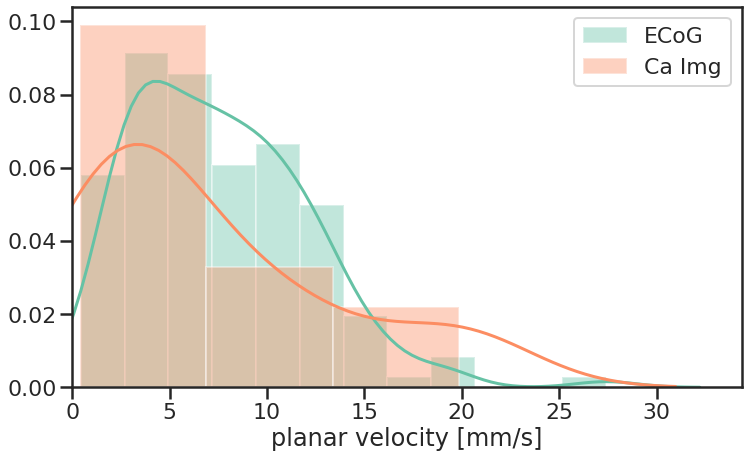

In [6]:
sns.set(style='ticks', context='poster', palette='Set2')
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(vdf_IDIBAPS['velocity'], hist=True, rug=False, norm_hist=True, ax=ax)
sns.distplot(vdf_LENS['velocity'], hist=True, rug=False, norm_hist=True, ax=ax)
plt.legend(['ECoG', 'Ca Img'])
ax.set_xlim((0,ax.get_xlim()[1]))
ax.set_xlabel('planar velocity [mm/s]')
plt.savefig('/home/rgutzen/Sciebo/own/Presentations/2020-02-05_HBP_UseCase_pipeline/images/velocity_comparison.png', bbox_inches='tight')

In [2]:
ddf_IDIBAPS = pd.read_csv(os.path.join(IDIBAPS_path, 'stage05_wave_characterization', 'direction', 'direction.csv'))
ddf_LENS = pd.read_csv(os.path.join(LENS_path, 'stage05_wave_characterization', 'direction', 'direction.csv'))

In [3]:
ddf_IDIBAPS

,wave_id,direction,direction_std
0,0,(0.8205472694562124+0.06846671696361206j),(3.0948609057487144+1.4902314633211042j)
1,1,(-1.3634068457811614+0.26650412131126866j),(2.470693031872217+1.3804667832970137j)
2,10,(3.453272727272747+0.6093116883116885j),(2.2831690602036807+1.3363526121984282j)
3,100,(3.3344575807457204+0.08478289883440837j),(1.8239491833054187+1.0266362416743338j)
4,101,(5.088862133656903+0.6362328124642715j),(0.932645256844355+1.0246410749115913j)
...,...,...,...
156,95,(2.787764353127841+0.2595361904817963j),(1.5900584548011807+0.9796474177258346j)
157,96,(1.316560340012586+0.44985338267119346j),(1.4023416362148344+0.6882185113566225j)
158,97,(3.989371641343041-0.08627553943104971j),(1.4759482511507713+1.4343386087134422j)
159,98,(3.951152473719958+0.09189651846855185j),(1.1013472010016523+1.3444400277560624j)


In [5]:
def str_to_cplx(string):
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace(' ', '')
    return complex(string)

In [6]:
d_IDIBAPS = np.array([str_to_cplx(item) for item in ddf_IDIBAPS['direction'].values])
d_LENS = np.array([str_to_cplx(item) for item in ddf_LENS['direction'].values])
d_IDIBAPS_std = np.array([str_to_cplx(item) for item in ddf_IDIBAPS['direction_std'].values])
d_LENS_std = np.array([str_to_cplx(item) for item in ddf_LENS['direction_std'].values])

In [24]:
def abs_direction(directions, directions_std):
    mds = [np.sqrt(np.real(d)**2+np.imag(d)**2) for d in directions]
    mds_std = [np.sqrt(np.real(d)**2+np.imag(d)**2) for d in directions_std]
    return mds, mds_std

def mean_direction(directions, directions_std):
    mds, mds_std = abs_direction(directions, directions_std)
    md = np.average(mds, weights=[1/std for std in mds_std])
    md_std = 1./np.sqrt(np.sum([1/std for std in mds_std]))
    return md, max([np.std(mds), md_std])

In [25]:
print(mean_direction(d_IDIBAPS, d_IDIBAPS_std))
print(mean_direction(d_LENS, d_LENS_std))

(2.8662701472137653, 1.2111774594169125)
(2.5364602331857498, 1.8757305133031275)


<ErrorbarContainer object of 3 artists>

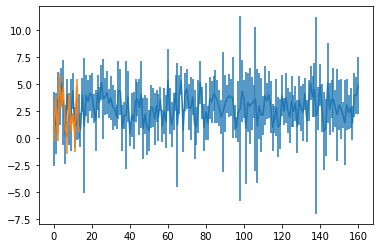

In [26]:
I = abs_direction(d_IDIBAPS, d_IDIBAPS_std)
L = abs_direction(d_LENS, d_LENS_std)
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(I[0])), I[0], yerr=I[1])
ax.errorbar(np.arange(len(L[0])), L[0], yerr=L[1])

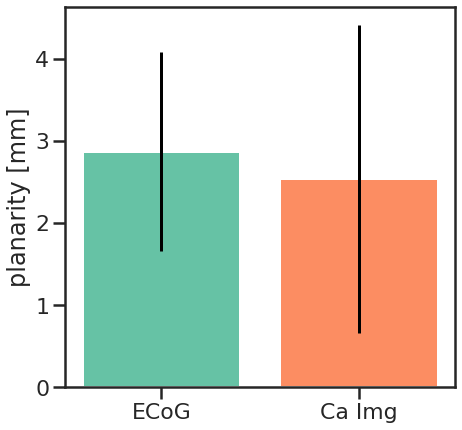

In [32]:
I = mean_direction(d_IDIBAPS, d_IDIBAPS_std)
L = mean_direction(d_LENS, d_LENS_std)

sns.set(style='ticks', context='poster', palette='Set2')
fig, ax = plt.subplots(figsize=(7,7))

ax.bar(0, I[0], yerr=I[1])
ax.bar(1, L[0], yerr=L[1])
ax.set_xticks([0,1])
ax.set_xticklabels(['ECoG', 'Ca Img'])
ax.set_ylabel('planarity [mm]')
plt.savefig('/home/rgutzen/Sciebo/own/Presentations/2020-02-05_HBP_UseCase_pipeline/images/planarity_comparison.png', bbox_inches='tight')

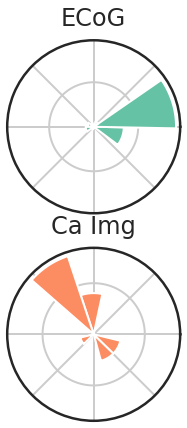

In [67]:
fig, ax = plt.subplots(figsize=(7,7))

ax = plt.subplot(2,1,1, projection='polar')

hist, edges = np.histogram(np.angle(d_IDIBAPS), density=True)
angles = edges[:-1] + (edges[1]-edges[0])/2
ax.bar(angles, hist, width=angles[1]-angles[0], color=sns.color_palette()[0], label='ECoG')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('ECoG')

ax = plt.subplot(2,1,2, projection='polar')

hist, edges = np.histogram(np.angle(d_LENS), density=True)
angles = edges[:-1] + (edges[1]-edges[0])/2
ax.bar(angles, hist, width=angles[1]-angles[0], color=sns.color_palette()[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Ca Img')
plt.savefig('/home/rgutzen/Sciebo/own/Presentations/2020-02-05_HBP_UseCase_pipeline/images/direction_comparison.png', bbox_inches='tight')